In [11]:
import numpy as np
import cv2
import random
import json
import pickle
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import colorsys
from matplotlib.widgets import Button
import ipywidgets as widgets
from IPython.display import display
import time
%matplotlib notebook

In [47]:
#path of files with results of previously done test of a model. Generally in "evaluator_output". Each one with the name to display
#a dictionary where the keys are the image id and the values are lists of bboxes. Each bbox is a list of 5 values:x,y,w,h and class
#x,y values are the center of the bbox instead of top left
#they all must have the results for every caption of at least the first one
results = {
    "TRAN2LY_UF" : "../TRAN2LY/evaluator_output/unfrozen_max/TESTINGepoch69.json",
    "STRAN2LY_UF" : "../STRAN2LY/evaluator_output/unfrozen/TESTINGepoch99.json"
}
#number of images to show
numImages = 100
#path of file coco instance
#its expected to have a 'categories' key containing a list of category objects.
#each category object has an 'id' key and a 'name' key.
#also an 'annotations' key containing a list of annotation objects
#each annotation object has an 'image_id' it belongs to, a 'bbox' and a 'category_id'
coco_instance = "../TRAN2LY/data/datasets/COCO/annotations/instances_val2014.json"
#idk how to describe this one. Go look at the example. Its complicated.
#must be the one used to make the results
captions = "../TRAN2LY/data/datasets/AMR2014train-dev-test/GraphTest.json"
captions_to_check = None
"""
captions_to_check = [  # set to None to get random images from the set
                    'a dirt covered floor in a home kitchen',
                    'a woman sitting with a boy cutting a cake',
                    'the baby zebra is standing near it’s mother',
                    'a man sliding into a base next to another baseball player',
                    'a tennis player contorts his body to make contact with the ball',
                    'a group of people sit around a table',
                    'a child flies a kite with another child onlooking',
                    'a dog looking up in at a frisbee'
                    ]
"""

"\ncaptions_to_check = [  # set to None to get random images from the set\n                    'a dirt covered floor in a home kitchen',\n                    'a woman sitting with a boy cutting a cake',\n                    'the baby zebra is standing near it’s mother',\n                    'a man sliding into a base next to another baseball player',\n                    'a tennis player contorts his body to make contact with the ball',\n                    'a group of people sit around a table',\n                    'a child flies a kite with another child onlooking',\n                    'a dog looking up in at a frisbee'\n                    ]\n"

In [48]:
results_data = {}
for key,value in results.items():
    with open(value, "r") as results_file:
        results_data[key] = json.load(results_file)
with open(captions, "r") as captions_file:
    captions_dict = json.load(captions_file)
with open(coco_instance, "r") as coco_instance_file:
    coco_info = json.load(coco_instance_file)

labelToClass_list = coco_info['categories']
annotations = coco_info['annotations'] #aka object bboxes


In [49]:
print(captions_dict[list(captions_dict.keys())[50]]['graphs'][0]['caption'])
#print([label['name'] for label in labelToClass_list])

the bathroom is clean for the guests to use


In [58]:
all_classes = [cat_obj['name'] for cat_obj in labelToClass_list]
def getClassName(class_id):
    for cat_obj in labelToClass_list:
        if cat_obj['id'] == class_id:
            return cat_obj['name']
    return None
def getObjects(image_id, image_width, image_height):
    global annotations
    objects = [] #each object has 5 elements: x,y,w,h of bbox and class. bbox is normalized to [0,1]

    for ann in annotations:
        if ann['image_id'] == image_id:
            obj = ann['bbox']
            obj[0], obj[1], obj[2], obj[3] = obj[0]/image_width, obj[1]/image_height, obj[2]/image_width, obj[3]/image_height
            obj.append(ann['category_id'])
            objects.append(obj)
    return objects

In [65]:
def draw_bboxes(img, bboxes, classes, xy_is_center=True):
    global all_classes
    img_w, img_h, _ = img.shape
    #generate range of colors. One for each class present in the image
    N = len(all_classes)
    HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
    RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    for i in range(len(classes)):
        x,y,w,h = bboxes[i]
        print('drawing bbox', x, y, w, h)
        c = classes[i]
        class_index = all_classes.index(c)
        class_color = RGB_tuples[class_index]
        if xy_is_center:
            start = int(img_w*(x-(w/2))), int(img_h*(y-(h/2)))
            end = int(img_w*(x+(w/2))), int(img_h*(y+(h/2)))
        else:
            start = int(img_w*(x)), int(img_h*(y))
            end = int(img_w*(x+w)), int(img_h*(y+h))
        print('start', start, 'end', end)
        img = cv2.rectangle(img, start, end, class_color, img_w//256)
        text_size = img_h//512
        text_origin = list(start)
        text_origin[1] = text_origin[1]+(text_size*20)
        
        img = cv2.putText(img, c, text_origin, cv2.FONT_HERSHEY_SIMPLEX, text_size, class_color)
    return img

In [66]:
#take all image ids from the first results file
first_results_name = list(results_data.keys())[0]
image_ids = list(results_data[first_results_name].keys())



if captions_to_check is not None:
    selected_image_ids = []
    for img_id in captions_dict:
        for xd in captions_dict[img_id]['graphs']:
            if xd['caption'] in captions_to_check:
                selected_image_ids.append(img_id)
                break
else:
    random_idx = np.random.randint(0, high=len(image_ids),size=numImages)
    selected_image_ids = [image_ids[i] for i in random_idx]
#print(len(captions_to_check))
#print(len(selected_image_ids))

In [67]:
#generate lists of images. For each selected image, generate image for ground truth and every results file given

#keys: name of model (or gt). values: list of images to display. 
images_dict = {}
bbox_dict = {}
#list of captions for each image to display
captions = []

#generate captions list
for img_id in selected_image_ids:
    caption = captions_dict[img_id]['graphs'][0]['caption'] #get first caption of the image
    captions.append(caption)
#generate gt list (different to models list)
images_dict['gt'] = []
bbox_dict['gt'] = []
for img_id in selected_image_ids:
    original_w, original_h = captions_dict[img_id]['width'], captions_dict[img_id]['height']
    gt = getObjects(int(img_id),original_w,original_h)
    gt = np.array(gt)
    gt_bboxes = gt[:,:4]
    gt_classes = gt[:,4]
    gt_class_names = [getClassName(c) for c in gt_classes]
    gt_img = np.ones((512,512,3)) #white canvas of 256x256 pixels
    gt_img = draw_bboxes(gt_img,gt_bboxes,gt_class_names, xy_is_center = False)
    images_dict['gt'].append(gt_img)
    bbox_dict['gt'].append((gt_bboxes, gt_class_names))
#generate models results list
for model_name, model_results in results_data.items():
    images_dict[model_name] = []
    bbox_dict[model_name] = []
    for img_id in selected_image_ids:
        result = model_results[img_id]
        result = np.array(result)
        bboxes = result[:,:4]
        classes = result[:,4]
        class_names = [getClassName(c) for c in classes]
        img = np.ones((512,512,3)) #white canvas of 512x512 pixels
        img = draw_bboxes(img,bboxes,class_names)

        images_dict[model_name].append(img)
        bbox_dict[model_name].append((bboxes,class_names))

drawing bbox 0.39390625 0.23782201405152223 0.373328125 0.5428337236533958
start (201, 121) end (392, 399)
drawing bbox 0.731640625 0.7334894613583138 0.014015625 0.03266978922716628
start (374, 375) end (381, 392)
drawing bbox 0.718515625 0.7319672131147541 0.014265625 0.026533957845433255
start (367, 374) end (375, 388)
drawing bbox 0.749484375 0.7320374707259952 0.01625 0.02629976580796253
start (383, 374) end (392, 388)
drawing bbox 0.6602812499999999 0.7437002341920375 0.017109375 0.03313817330210773
start (338, 380) end (346, 397)
drawing bbox 0.6852343750000001 0.7533723653395784 0.01496875 0.027259953161592507
start (350, 385) end (358, 399)
drawing bbox 0.363859375 0.6913348946135831 0.1928125 0.14730679156908666
start (186, 353) end (285, 429)
drawing bbox 0.68378125 0.7453161592505855 0.011296875000000001 0.0239344262295082
start (350, 381) end (355, 393)
drawing bbox 0.675875 0.7462763466042155 0.011 0.02257611241217799
start (346, 382) end (351, 393)
drawing bbox 0.0019107

drawing bbox 0.2911647727272727 0.5150869565217391 0.02244318181818182 0.07526086956521738
start (149, 263) end (160, 302)
drawing bbox 0.07528409090909091 0.9358695652173913 0.1747159090909091 0.06304347826086956
start (38, 479) end (128, 511)
drawing bbox 0.3309659090909091 0.8242173913043478 0.14204545454545456 0.1108695652173913
start (169, 421) end (242, 478)
drawing bbox 0.22599431818181817 0.7741304347826088 0.5919318181818182 0.21173913043478262
start (115, 396) end (418, 504)
drawing bbox 0.8574999999999999 0.3258260869565217 0.1409659090909091 0.6584347826086956
start (439, 166) end (511, 503)
drawing bbox 0.6268465909090909 0.7779565217391304 0.10750000000000001 0.12134782608695652
start (320, 398) end (375, 460)
drawing bbox 0.39053977272727275 0.539608695652174 0.17096590909090909 0.30878260869565216
start (199, 276) end (287, 434)
drawing bbox 0.7566193181818182 0.5847391304347827 0.07917613636363637 0.015086956521739131
start (387, 299) end (427, 307)
drawing bbox 0.6129

drawing bbox 0.71284375 0.2922352941176471 0.054593749999999996 0.03684705882352941
start (364, 149) end (392, 168)
drawing bbox 0.598625 0.29515294117647056 0.020984375 0.03051764705882353
start (306, 151) end (317, 166)
drawing bbox 0.42951562499999996 0.2943529411764706 0.020749999999999998 0.032611764705882354
start (219, 150) end (230, 167)
drawing bbox 0.8036406250000001 0.35818823529411764 0.011234375000000001 0.029882352941176468
start (411, 183) end (417, 198)
drawing bbox 0.748046875 0.37743529411764704 0.0080625 0.012305882352941177
start (383, 193) end (387, 199)
drawing bbox 0.6927187499999999 0.37454117647058827 0.006109375 0.016894117647058823
start (354, 191) end (357, 200)
drawing bbox 0.652109375 0.3605411764705882 0.013140625 0.02496470588235294
start (333, 184) end (340, 197)
drawing bbox 0.389953125 0.35263529411764705 0.02034375 0.038564705882352945
start (199, 180) end (210, 200)
drawing bbox 0.46115625 0.2944941176470588 0.017234375 0.032988235294117645
start (2

drawing bbox 0.33548 0.52904 0.12258 0.13332
start (171, 270) end (234, 339)
drawing bbox 0.66946 0.72672 0.24824000000000002 0.2095
start (342, 372) end (469, 479)
drawing bbox 0.37304000000000004 0.35578 0.06506 0.17546
start (190, 182) end (224, 271)
drawing bbox 0.66822 0.23034000000000002 0.0639 0.1017
start (342, 117) end (374, 170)
drawing bbox 0.27376 0.14906 0.061399999999999996 0.18144
start (140, 76) end (171, 169)
drawing bbox 0.33882 0.06486 0.1764 0.26732
start (173, 33) end (263, 170)
drawing bbox 0.69616 0.34054 0.21104 0.32616
start (356, 174) end (464, 341)
drawing bbox 0.85224 0.50956 0.09892000000000001 0.15456
start (436, 260) end (486, 340)
drawing bbox 0.5595 0.19804 0.10859999999999999 0.13746
start (286, 101) end (342, 171)
drawing bbox 0.33656 0.53998 0.11322 0.09934
start (172, 276) end (230, 327)
drawing bbox 0.11878 0.21202000000000001 0.01834 0.03836
start (60, 108) end (70, 128)
drawing bbox 0.5647000000000001 0.54344 0.0089 0.03324
start (289, 278) end (

drawing bbox 0.521296875 0.13626931567328918 0.361875 0.4144150110375276
start (266, 69) end (452, 281)
drawing bbox 0.24748437499999998 0.28147902869757174 0.41196875000000005 0.64719646799117
start (126, 144) end (337, 475)
drawing bbox 0.5078125 0.22671081677704194 0.22146875000000002 0.321766004415011
start (260, 116) end (373, 280)
drawing bbox 0.5976874999999999 0.2868211920529801 0.14975 0.0775496688741722
start (306, 146) end (382, 186)
drawing bbox 0.2866875 0.1963231850117096 0.090546875 0.3311943793911007
start (146, 100) end (193, 270)
drawing bbox 0.25798437500000004 0.4949882903981265 0.13865624999999998 0.037611241217798595
start (132, 253) end (203, 272)
drawing bbox 0.518234375 0.2718032786885246 0.03609375 0.06775175644028103
start (265, 139) end (283, 173)
drawing bbox 0.47553124999999996 0.2119672131147541 0.11590625000000002 0.31002341920374704
start (243, 108) end (302, 267)
drawing bbox 0.08803921568627451 0.05772875816993464 0.8972385620915033 0.8288398692810458

drawing bbox 0.7450802139037433 0.90006 0.05366310160427808 0.09652
start (381, 460) end (408, 510)
drawing bbox 0.8603475935828877 0.8715599999999999 0.11310160427807486 0.09764
start (440, 446) end (498, 496)
drawing bbox 0.3845454545454545 0.32133999999999996 0.09914438502673796 0.16854
start (196, 164) end (247, 250)
drawing bbox 0.7103475935828878 0.3365 0.07868983957219251 0.14422
start (363, 172) end (403, 246)
drawing bbox 0.8752673796791445 0.94238 0.03590909090909091 0.029
start (448, 482) end (466, 497)
drawing bbox 0.736096256684492 0.97138 0.06497326203208556 0.02862
start (376, 497) end (410, 512)
drawing bbox 0.0005347593582887701 0.81956 0.14657754010695187 0.06192
start (0, 419) end (75, 451)
drawing bbox 0.7458288770053476 0.93948 0.2541711229946524 0.060520000000000004
start (381, 481) end (512, 512)
drawing bbox 0.6969518716577541 0.87012 0.07042780748663102 0.12986
start (356, 445) end (392, 511)
drawing bbox 0.0 0.07176 0.95516 0.9148000000000001
start (0, 36) end

drawing bbox 0.19556485355648537 0.161953125 0.6438912133891213 0.82246875
start (100, 82) end (429, 504)
drawing bbox 0.4868828451882845 0.4649375 0.1147489539748954 0.4
start (249, 238) end (308, 442)
drawing bbox 0.7191803278688524 0.54484375 0.20833723653395783 0.22196875
start (368, 278) end (474, 392)
drawing bbox 0.07908665105386417 0.5009375 0.34166276346604213 0.164203125
start (40, 256) end (215, 340)
drawing bbox 0.2694 0.16180180180180181 0.53428 0.626966966966967
start (137, 82) end (411, 403)
drawing bbox 0.1736 0.0028228228228228225 0.6944400000000001 0.7056156156156156
start (88, 1) end (444, 362)
drawing bbox 0.013442622950819673 0.033890625 0.9342388758782202 0.952921875
start (6, 17) end (485, 505)
drawing bbox 0.030374707259953164 0.7183125 0.9696252927400468 0.231984375
start (15, 367) end (512, 486)
drawing bbox 0.7096955503512881 0.5376562500000001 0.03718969555035129 0.011640625
start (363, 275) end (382, 281)
drawing bbox 0.2562763466042155 0.30207812500000003 

drawing bbox 0.13870312499999998 0.2967708333333333 0.735484375 0.49893750000000003
start (71, 151) end (447, 407)
drawing bbox 0.7644062500000001 0.22933333333333333 0.040859374999999996 0.11004166666666666
start (391, 117) end (412, 173)
drawing bbox 0.9206562500000001 0.05254166666666667 0.078890625 0.06839583333333334
start (471, 26) end (511, 61)
drawing bbox 0.187078125 0.03820833333333333 0.54775 0.6853958333333333
start (95, 19) end (376, 370)
drawing bbox 0.029593750000000002 0.07127083333333334 0.07859374999999999 0.21839583333333332
start (15, 36) end (55, 148)
drawing bbox 0.31272916666666667 0.49421875000000004 0.5497708333333333 0.35728125
start (160, 253) end (441, 435)
drawing bbox 0.34525 0.407640625 0.3095625 0.414828125
start (176, 208) end (335, 421)
drawing bbox 0.40510416666666665 0.36140625000000004 0.14316666666666666 0.30771875
start (207, 185) end (280, 342)
drawing bbox 0.32583333333333336 0.352078125 0.009083333333333334 0.012859375000000001
start (166, 180)

drawing bbox 0.91075 0.5397169811320754 0.05840625000000001 0.13816037735849057
start (466, 276) end (496, 347)
drawing bbox 0.75628125 0.42910377358490565 0.028265625 0.1868632075471698
start (387, 219) end (401, 315)
drawing bbox 0.46003125 0.13033018867924528 0.203953125 0.8561792452830188
start (235, 66) end (339, 505)
drawing bbox 0.1761875 0.1516509433962264 0.34362499999999996 0.8373584905660378
start (90, 77) end (266, 506)
drawing bbox 0.789890625 0.6143867924528302 0.104609375 0.0705188679245283
start (404, 314) end (457, 350)
drawing bbox 0.168171875 0.6237735849056604 0.059859375000000006 0.0627122641509434
start (86, 319) end (116, 351)
drawing bbox 0.9209375 0.7623584905660378 0.078078125 0.16356132075471697
start (471, 390) end (511, 474)
drawing bbox 0.140796875 0.7479952830188679 0.159671875 0.11233490566037736
start (72, 382) end (153, 440)
drawing bbox 0.8211562499999999 0.48375 0.049953125 0.06775943396226415
start (420, 247) end (446, 282)
drawing bbox 0.815421875 

drawing bbox 0.53125 0.53125 0.43865951895713806 0.8953390717506409
start (159, 42) end (384, 501)
drawing bbox 0.53125 0.53125 0.4014590084552765 0.7926155924797058
start (169, 69) end (374, 474)
drawing bbox 0.0 0.0 0.34187379479408264 0.5780268907546997
start (-87, -147) end (87, 147)
drawing bbox 0.09375 0.59375 0.22897297143936157 0.4860265254974365
start (-10, 179) end (106, 428)
drawing bbox 0.0 0.0 0.17502740025520325 0.41086694598197937
start (-44, -105) end (44, 105)
drawing bbox 0.6875 0.625 0.42165106534957886 0.8968062400817871
start (244, 90) end (459, 549)
drawing bbox 0.875 0.15625 0.4575052559375763 0.27331307530403137
start (330, 10) end (565, 149)
drawing bbox 0.0 0.0 0.098041832447052 0.1858919858932495
start (-25, -47) end (25, 47)
drawing bbox 0.875 0.34375 0.07284291088581085 0.045734696090221405
start (429, 164) end (466, 187)
drawing bbox 0.5625 0.5625 0.26553764939308167 0.8557636737823486
start (220, 68) end (355, 507)
drawing bbox 0.90625 0.4375 0.1504461914

drawing bbox 0.34375 0.3125 0.42006710171699524 0.3469311594963074
start (68, 71) end (283, 248)
drawing bbox 0.875 0.5 0.3286510407924652 0.309806227684021
start (363, 176) end (532, 335)
drawing bbox 0.5625 0.5625 0.33176830410957336 0.2677704393863678
start (203, 219) end (372, 356)
drawing bbox 0.21875 0.34375 0.3298935294151306 0.2419024556875229
start (27, 114) end (196, 237)
drawing bbox 0.6875 0.59375 0.3187144994735718 0.1653897911310196
start (270, 261) end (433, 346)
drawing bbox 0.65625 0.625 0.2803971767425537 0.14418752491474152
start (264, 283) end (407, 356)
drawing bbox 0.4375 0.6875 0.5338546633720398 0.3644605875015259
start (87, 258) end (360, 445)
drawing bbox 0.625 0.375 0.29890012741088867 0.2265750616788864
start (243, 133) end (396, 250)
drawing bbox 0.5625 0.59375 0.18689213693141937 0.17439928650856018
start (240, 259) end (335, 348)
drawing bbox 0.0625 0.46875 0.1911715567111969 0.11393285542726517
start (-16, 210) end (80, 269)
drawing bbox 0.75 0.34375 0.1

drawing bbox 0.40625 0.625 0.3468554615974426 0.6087479591369629
start (119, 164) end (296, 475)
drawing bbox 0.40625 0.625 0.2701227068901062 0.4060342013835907
start (138, 216) end (277, 423)
drawing bbox 0.71875 0.78125 0.11569198966026306 0.1660197675228119
start (338, 357) end (397, 442)
drawing bbox 0.4375 0.25 0.07258289307355881 0.06333208829164505
start (205, 111) end (242, 144)
drawing bbox 0.46875 0.34375 0.03078501485288143 0.05192316696047783
start (232, 162) end (247, 189)
drawing bbox 0.5 0.5625 0.9722281098365784 0.9400312900543213
start (7, 47) end (504, 528)
drawing bbox 0.46875 0.75 0.13793329894542694 0.17428776621818542
start (204, 339) end (275, 428)
drawing bbox 0.875 0.5625 0.2912026643753052 0.32774266600608826
start (373, 204) end (522, 371)
drawing bbox 0.125 0.625 0.25729358196258545 0.1332082450389862
start (-1, 285) end (129, 354)
drawing bbox 0.75 0.53125 0.7273968458175659 0.7885726094245911
start (197, 70) end (570, 473)
drawing bbox 0.6875 0.875 0.3665

<IPython.core.display.Javascript object>


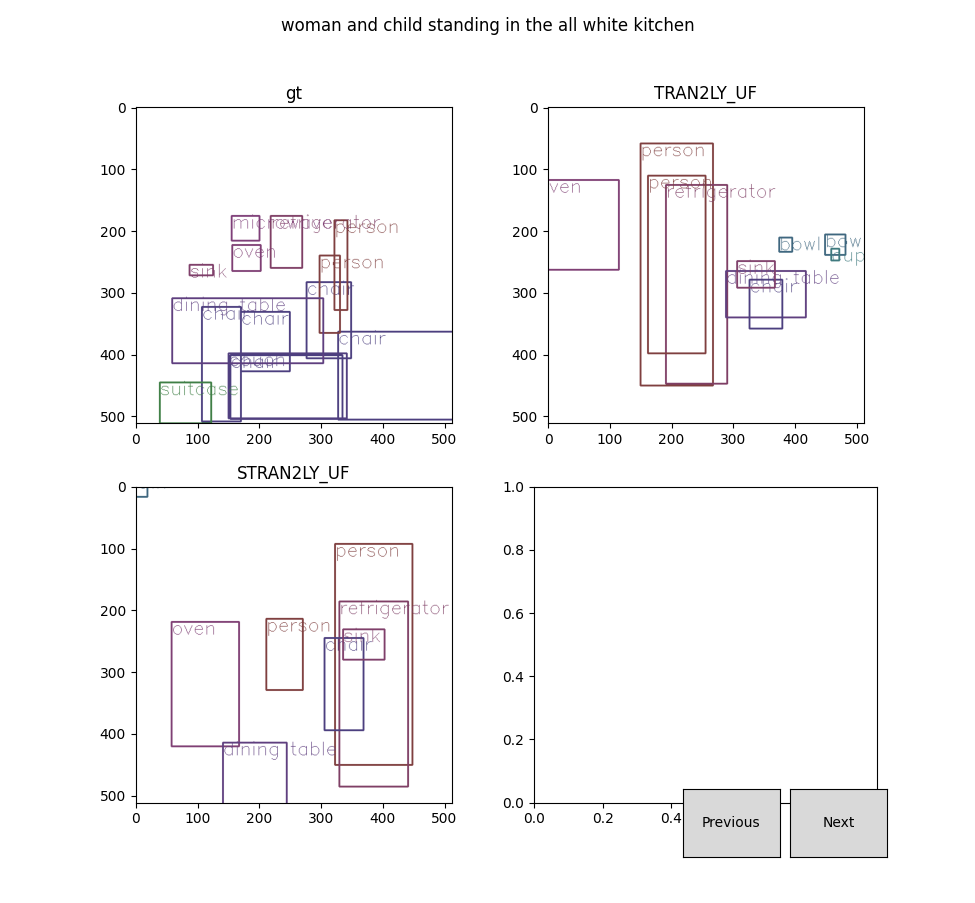

In [68]:
numRows = int(np.ceil(len(images_dict.keys()) / 2))
fig, ax = plt.subplots(numRows,2, figsize=(10,5))
# fig, ax = plt.subplots(1, figsize=(10,5))  # to manually force only gt to appear
ind = 0
#in each ax draws the corresponding image. It also updates title
def draw_images():
    global ind
    global ax
    global images_dict
    global fig
    global captions
    fig.suptitle(captions[ind])
    model_names = list(images_dict.keys())
    model_images = list(images_dict.values())
    for i in range(len(model_names)):
        if False:  # manually force only gt to appear
            ax.clear()
            ax.imshow(model_images[0][ind])
            ax.set_title(model_names[0])
        elif len(model_names) < 3:
            col = i%2
            ax[col].clear()
            ax[col].imshow(model_images[i][ind])
            ax[col].set_title(model_names[i])
        else:
            col = i%2
            row = i//2
            ax[row,col].clear()
            ax[row,col].imshow(model_images[i][ind])
            ax[row,col].set_title(model_names[i])
            
def siguiente(event):
    global ind
    global numImages
    ind = min(numImages-1,ind+1)
    draw_images()
def anterior(event):
    global ind
    global numImages
    ind = max(0,ind-1)
    draw_images()
axprev = plt.axes([0.7, 0.05, 0.1, 0.075])
axnext = plt.axes([0.81, 0.05, 0.1, 0.075])
bnext = Button(axnext, 'Next')
bnext.on_clicked(siguiente)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(anterior)
anterior("ekisde")
plt.show()

In [57]:
print(annotations[0])

{'segmentation': [[239.97, 260.24, 222.04, 270.49, 199.84, 253.41, 213.5, 227.79, 259.62, 200.46, 274.13, 202.17, 277.55, 210.71, 249.37, 253.41, 237.41, 264.51, 242.54, 261.95, 228.87, 271.34]], 'area': 2765.1486500000005, 'iscrowd': 0, 'image_id': 558840, 'bbox': [199.84, 200.46, 77.71, 70.88], 'category_id': 58, 'id': 156}


In [111]:
print(ind)

0


In [120]:
print(captions[ind])
wut = list(bbox_dict.values())[0][ind]
for i in range(len(wut[0])):
    x,y,w,h = wut[0][i]
    print(wut[1][i], x+(w/2), y+(h/2), w, h, x*512+(w*512)//2, y*512+(h*512//2), w*512, h*512)
print(list(bbox_dict.values())[0][ind])
print(len(list(bbox_dict.values())[0][ind]))

a white dog having its hair blown dry by a man
dog 0.6709921875 0.5193544600938967 0.43479687499999997 0.9395070422535212 343.24 265.3956807511737 222.61599999999999 481.02760563380286
hair drier 0.3463515625 0.6373826291079813 0.283421875 0.4265023474178404 176.776 326.15530516431926 145.112 218.36920187793427
person 0.28065625000000005 0.49753521126760564 0.5581875000000001 0.9573239436619718 142.8 254.6630985915493 285.79200000000003 490.1498591549296
(array([[0.45359375, 0.04960094, 0.43479687, 0.93950704],
       [0.20464062, 0.42413146, 0.28342187, 0.42650235],
       [0.0015625 , 0.01887324, 0.5581875 , 0.95732394]]), ['dog', 'hair drier', 'person'])
2


drawing bbox 0.45359375 0.049600938967136146 0.43479687499999997 0.9395070422535212
start (232, 25) end (454, 506)
drawing bbox 0.204640625 0.42413145539906105 0.283421875 0.4265023474178404
start (104, 217) end (249, 435)
drawing bbox 0.0015625 0.018873239436619716 0.5581875000000001 0.9573239436619718
start (0, 9) end (286, 499)


<IPython.core.display.Javascript object>


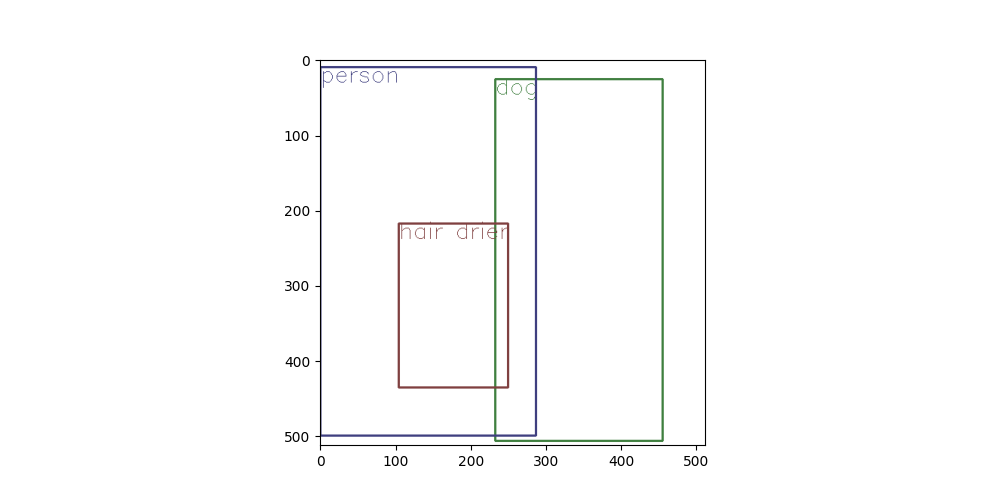

In [118]:
img = np.ones((512,512,3)) #white canvas of 512x512 pixels
img = draw_bboxes(img,wut[0],wut[1], xy_is_center=False)
fig, ax = plt.subplots(1, figsize=(10,5))
ax.imshow(img)

In [69]:
kek = [
    'woman and child standing in the all white kitchen'
]
for img_id in captions_dict:
        for xd in captions_dict[img_id]['graphs']:
            if xd['caption'] in kek:
                print(xd['caption'], img_id)

woman and child standing in the all white kitchen 141017
